# Адаптивные методы

## Основная часть

__Внимание: эта часть домашнего задания про ML, поэтому если у вас на локальном устройстве недоступна CUDA, то настоятельно рекомендуем воспользоваться google collab или же kaggle__

In [1]:
import math
import time
import warnings
from functools import partial
from typing import Callable, Iterator
import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

__Задача 1 (5 баллов).__ В данном домашнем задании мы рассмотрим обучение небольших сверточных сетей для классификации датасета CIFAR10. Так как в большинстве случаев при работе с сетками, имеющими не один, а несколько слоев, функции потерь становятся невыпуклыми, удобно использовать проксимальные методы. В нашем случае мы рассмотрим семейство адаптивных методов, таких как ```AdaGrad```, ```RMSProp```и ```Adam```. 

Files already downloaded and verified
Files already downloaded and verified
len(cifar_train_dataset)=25000
len(cifar_test_dataset)=5000


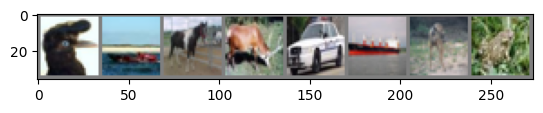

bird  ship  horse deer  car   ship  deer  frog 


In [3]:
cifar_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
# загружаем датасет
cifar_train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=cifar_transform
)
cifar_test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=cifar_transform
)
# будем использовать только часть данных
cifar_ratio = 0.5
# делим данные train и test
cifar_train_dataset, _ = random_split(
    cifar_train_dataset,
    [cifar_ratio, 1 - cifar_ratio],
    generator=torch.Generator().manual_seed(420),
)
cifar_test_dataset, _ = random_split(
    cifar_test_dataset,
    [cifar_ratio, 1 - cifar_ratio],
    generator=torch.Generator().manual_seed(420),
)
print(f"{len(cifar_train_dataset)=}")
print(f"{len(cifar_test_dataset)=}")
assert len(cifar_train_dataset) == 25000
assert len(cifar_test_dataset) == 5000
cifar_train_loader = DataLoader(
    cifar_train_dataset, batch_size=16, shuffle=True
)
cifar_test_loader = DataLoader(
    cifar_test_dataset, batch_size=256, shuffle=False
)
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)
def imshow(image):
    image = image / 2 + 0.5  # де-нормализуем
    np_image = image.numpy()
    plt.imshow(np.transpose(np_image, (1, 2, 0)))
    plt.show()
# несколько случайных элементов
images, labels = next(iter(cifar_train_loader))
images, labels = images[:8], labels[:8]
# выведем изображения
imshow(torchvision.utils.make_grid(images))
# выведем метки
print(" ".join(f"{classes[labels[j]]:5s}" for j in range(8)))

Далее уже написана модель со следующими слоями. Подробнее про них вы можете прочитать в документации torch.

1. Сверточный слой 1:  ```Conv2d(in=3, out=6, kernel=5)```;

2. Пулинговый слой: ```MaxPool2d(kernel=2, stride=2)```;

3. Сверточный слой 2:  ```Conv2d(in=6, out=16, kernel=5)```;

4. Полносвязный слой 1: ```Linear(400, 120)```;

5. Полносвязный слой 2: ```Linear(120, 84)```;

6. Полносвязный слой 3: ```Linear(84, 10)```.



```forward``` функция:

1. Свертка первым слоем -> функция активации (ReLU) -> пулинг;

2. Свертка вторым слоем -> функция активации (ReLU) -> пулинг;

3. Полносвязный слой 1 -> функция активации (ReLU);

4. Полносвязный слой 2 -> функция активации (ReLU);

5. Выход - значение на полносвязном слое 3.

In [4]:
class CifarNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

Проверьте с помощью функции ниже, что у вашей модели 62006 обучаемых параметров.

In [5]:
def print_model_summary(model, input_size):
    def register_hook(module):
        def hook(module, input, output):
            class_name = str(module.__class__).split(".")[-1].split("'")[0]
            module_idx = len(summary)
            m_key = f"{class_name}-{module_idx+1}"
            summary[m_key] = {
                "input_shape": list(input[0].size()),
                "output_shape": list(output.size()),
                "nb_params": sum(p.numel() for p in module.parameters())
            }
        if not isinstance(module, nn.Sequential) and not isinstance(module, nn.ModuleList) and module != model:
            hooks.append(module.register_forward_hook(hook))
    summary = {}
    hooks = []
    model.apply(register_hook)
    with torch.no_grad():
        model(torch.zeros(1, *input_size))
    for h in hooks:
        h.remove()
    print("----------------------------------------------------------------")
    line_new = "{:>20}  {:>25} {:>15}".format("Layer (type)", "Output Shape", "Param #")
    print(line_new)
    print("================================================================")
    total_params = 0
    for layer in summary:
        line_new = "{:>20}  {:>25} {:>15}".format(
            layer,
            str(summary[layer]["output_shape"]),
            "{0:,}".format(summary[layer]["nb_params"])
        )
        total_params += summary[layer]["nb_params"]
        print(line_new)
    print("================================================================")
    print(f"Total params: {total_params:,}")
    print("----------------------------------------------------------------")
model = CifarNet()
print_model_summary(model, (3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [1, 6, 28, 28]             456
         MaxPool2d-2             [1, 6, 14, 14]               0
            Conv2d-3            [1, 16, 10, 10]           2,416
         MaxPool2d-4              [1, 16, 5, 5]               0
            Linear-5                   [1, 120]          48,120
            Linear-6                    [1, 84]          10,164
            Linear-7                    [1, 10]             850
Total params: 62,006
----------------------------------------------------------------


__а) (0.25 балла)__ Дополните функции обучения (```train_cifar```) и подсчета метрик (```eval_cifar```). 

In [6]:
def train_cifar(
    model: nn.Module, optimizer: torch.optim.Optimizer, **loss_kwargs
) -> None:
    loss_fn = nn.CrossEntropyLoss()
    model.train()
    for inputs, labels in cifar_train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        # Обнулите градиенты
        optimizer.zero_grad()
        # Получите выход модели
        output = model(inputs)
        # Подсчитайте функцию потерь
        loss = loss_fn(output, labels)
        loss.backward(**loss_kwargs)
        optimizer.step()

def eval_cifar(model: nn.Module) -> tuple[float, float]:
    loss_fn = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        model.eval()
        for inputs, labels in cifar_test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            # Для подсчета accuracy нам понадобится найти отношение
            # правильно предсказанных меток ко всем меткам            
            total += len(labels)
            correct += (predicted == labels).float().sum()
            # Подсчитайте значение валидационной ошибки
            val_loss += loss_fn(outputs, labels).item()
            
    return val_loss, correct / total

__б) (0.25 балла)__ Реализуйте функцию логгирования результатов, полученных при обучении, заполнив пропуски.

In [7]:
def check_optimizers_cifar(
    optimizers: list[
        tuple[str, Callable[[Iterator[nn.Parameter]], torch.optim.Optimizer]]
    ],
    epochs: int = 20,
    model_class: Callable[[], nn.Module] = CifarNet,
) -> dict:
    results_dict = {}
    for name, optimizer_lambda in optimizers:
        test_losses = []
        accuracies = []
        time_logs = []
        torch.manual_seed(420)
        model = model_class().to(DEVICE)
        optimizer = optimizer_lambda(model.parameters())

        # Начальная инициализация eval
        loss, accuracy = eval_cifar(model)
        test_losses.append(loss)
        accuracies.append(accuracy)
        # Произведите логгирование
        print(f"\n{name} --------- EPOCH 0: Loss {loss:.4}, Accuracy {accuracy:.2%}")

        torch.cuda.synchronize()
        start_time = time.time()
        with tqdm(range(epochs), desc=name) as loop:
            for epoch in loop:

                # Обучающий режим (ОБЯЗАТЕЛЬНО сохраним граф вычислений, используя create_graph=True)
                train_cifar(model, optimizer, create_graph=True)
                # Подсчет функции потерь и accuracy
                loss, accuracy = eval_cifar(model)
                test_losses.append(loss)
                accuracies.append(accuracy)
                # Произведите логгирование                
                torch.cuda.synchronize()
                time_logs.append(time.time() - start_time)
                loop.set_postfix_str(f"Loss {loss:.4}, Accuracy {accuracy:.2%}")
                
        results_dict[name] = {
            "Epoch": list(range(epochs + 1)),
            "Time": time_logs,
            "Test Loss": test_losses,
            "Accuracy": accuracies,
        }
    return results_dict

__в) (0.75 балла)__ Перейдем к написанию оптимизационных методов. Реализуйте первый из адаптивных методов ```AdaGrad```. Для предотвращаения переобучения будем использовать $L_2$ регуляризацию весов (добавление члена $\frac{\lambda}{2} \| x \|_2^2$ к значению функции потерь).



**Псевдокод алгоритма**



_Инициализация:_



Величина шага $\{ \gamma_k \}_{k=0} > 0$, регуляризатор $\lambda$, константа уменьшения шага $\eta$, бегущее среднее (аккумулятор градиентов) $s_0 = 0$.



$k \hspace{-1em}$ _--ая итерация:_

1. Подсчитать градиент $g_{k + 1} = \nabla f(x_k)$

2. Обновить шаг

$$\gamma_{k + 1 } = \frac{\gamma_k}{1 + k\eta} $$

3. Если параметр регуляризации $\lambda$ не равен 0, добавить регуляризационный член:

$$\hat{g}_{k + 1} = g_{k + 1} + \lambda x$$

4. Обновить бегущее среднее, добавив $\hat{g}_{k + 1}^2$

$$s_{k + 1} = s_k + \hat{g}_{k + 1}^2$$

5. Сделать шаг алгоритма (для вычислительной стабильности используйте $\varepsilon = 10^{-8}$)

$$ x^{k+1} = x^k - \gamma_{k + 1} \frac{\hat{g}_{k + 1}}{\sqrt{s_{k + 1}} + \varepsilon} $$

In [8]:
from torch.optim.optimizer import Optimizer
class Adagrad(Optimizer):
    """
    Implements Adagrad algorithm.
    It has been proposed in `Adaptive Subgradient Methods for Online Learning and Stochastic Optimization`.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-2)
        lr_decay (float, optional): learning rate decay (default: 0)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
    .. _Adaptive Subgradient Methods for Online Learning and Stochastic Optimization:
        http://jmlr.org/papers/v12/duchi11a.html
    """
    def __init__(self, params, lr=1e-2, lr_decay=0, eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, lr_decay=lr_decay, eps=eps, weight_decay=weight_decay)
        super(Adagrad, self).__init__(params, defaults)
        for group in self.param_groups:
            for p in group['params']:
                self.state[p] = {"sum_squared": torch.zeros_like(p.data)}
    def step(self, closure=None):
        """
        Performs a single optimization step.
        
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            for p in group['params']:

                if "step" not in self.state[p].keys():
                    self.state[p]["step"] = 0
                self.state[p]["step"] += 1
                # Ваше решение
                if group["weight_decay"] != 0:
                    p.grad.data.add_(p.data, alpha=group["weight_decay"])
                self.state[p]["sum_squared"].add_(p.grad.data.pow(2))
                denominator = self.state[p]["sum_squared"].sqrt().add_(group['eps'])
                p.data.add_(-group["lr"] * p.grad.data / denominator)
                group["lr"] = group["lr"] / (1 + self.state[p]["step"] * group["lr_decay"])
                
        return loss

__г) (0.75 балла)__ Теперь реализуем ```RMSProp```. Основным отличием является менее аггресивное обновление бегущего среднего градиентов через использования момента $\alpha_k$.



**Псевдокод алгоритма**



_Инициализация:_



Величина шага $\{ \gamma_k \}_{k=0} > 0$, момент $\alpha_k > 0$, регуляризатор $\lambda$, бегущее среднее $s_0 = 0$.



$k \hspace{-1em}$ _--ая итерация:_

1. Подсчитать градиент $g_{k + 1} = \nabla f(x_k)$

2. Если параметр регуляризации $\lambda$ не равен 0, добавить регуляризационный член:

$$\hat{g}_{k + 1} = g_{k + 1} + \lambda x$$

4. Обновить бегущее среднее

$$
s_{k + 1} = \alpha_k s_k + (1 - \alpha_k) \hat{g}_{k + 1}^2
$$

5. Сделать шаг алгоритма (для вычислительной стабильности используйте $\varepsilon = 10^{-8}$)

$$ x^{k+1} = x^k - \gamma_{k + 1} \frac{\hat{g}_{k + 1}}{\sqrt{s_{k + 1}} + \varepsilon} $$

In [9]:
class RMSprop(Optimizer):
    """
    Implements RMSprop algorithm, proposed by G. Hinton in his
    `course <http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf>`
    
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-2)
        alpha (float, optional): smoothing constant (default: 0.99)
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
    """
    def __init__(self, params, lr=1e-2, alpha=0.99, eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, alpha=alpha, eps=eps, weight_decay=weight_decay)
        super(RMSprop, self).__init__(params, defaults)
        for group in self.param_groups:
            for p in group['params']:
                self.state[p] = {"sum_squared": torch.zeros_like(p.data)}
    def step(self, closure=None):
        """
        Performs a single optimization step.
        
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            for p in group['params']:

                if "step" not in self.state[p].keys():
                    self.state[p]["step"] = 0
                self.state[p]["step"] += 1
                # Ваше решение
                if group["weight_decay"] != 0:
                    p.grad.data.add_(p.data, alpha=group["weight_decay"])
                self.state[p]["sum_squared"].mul_(group["alpha"]).addcmul_(p.grad.data, p.grad.data, value=(1 - group["alpha"]))
                denominator = self.state[p]["sum_squared"].sqrt().add_(group['eps'])
                p.data.add_(-group["lr"] * p.grad.data / denominator)
        return loss


__д) (0.75 балла)__ Перейдем к самому популярному алгоритму оптимизации ```Adam```. В нем добавляется еще один момент для обновления среднего градиентов. 



**Псевдокод алгоритма**



_Инициализация:_



Величина шага $\{ \gamma_k \}_{k=0} > 0$, моменты $\beta_, \beta_2 > 0$, регуляризатор $\lambda$, усредненный градиентный момент $m_0 = 0$, бегущее среднее (второй момент) $v_0 = 0$.



$k \hspace{-1em}$ _--ая итерация:_

1. Подсчитать градиент $g_{k + 1} = \nabla f(x_k)$

2. Если параметр регуляризации $\lambda$ не равен 0, добавить регуляризационный член:

$$
\hat{g}_{k + 1} = g_{k + 1} + \lambda x
$$

4. Обновить первый момент

$$
m_{k + 1} = \beta_1 m_k + (1 - \beta_1) \hat{g}_k
$$

5. Обновить второй момент

$$
v_{k + 1} = \beta_2 v_k + (1 - \beta_2) \hat{g}_{k + 1}^2
$$

6. Выполнить поправку смещения

$$
\hat{m}_{k + 1} = \frac{m_{k + 1}}{\sqrt{1 + \beta_1^k}} \qquad \hat{v}_{k + 1} = \frac{v_{k + 1}}{\sqrt{1 + \beta_2^k}}   
$$

5. Сделать шаг алгоритма (для вычислительной стабильности используйте $\varepsilon = 10^{-8}$)

$$ x^{k+1} = x^k - \gamma_{k + 1} \frac{\hat{m}_{k + 1}}{\sqrt{\hat{v}_{k + 1}} + \varepsilon} $$

In [22]:
class Adam(torch.optim.Optimizer):
    """
    Implements Adam algorithm, proposed in the paper
    `Adam: A Method for Stochastic Optimization` 
    by Kingma and Ba <https://arxiv.org/abs/1412.6980>`
    
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (tuple, optional): contains two momentums' values
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
    """
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay: float = 1e-2,):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super(Adam, self).__init__(params, defaults)
        for group in self.param_groups:
            for p in group['params']:
                self.state[p] = {"m": torch.zeros_like(p.data),
                                 "v": torch.zeros_like(p.data)}
   
    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
        for group in self.param_groups:
            for p in group["params"]:
                
                if "step" not in self.state[p].keys():
                    self.state[p]["step"] = 0
                self.state[p]["step"] += 1
                # Ваше решение
                if group["weight_decay"] != 0:
                    p.grad.data.add_(p.data, alpha=group["weight_decay"])
                self.state[p]["m"].mul_(group["betas"][0]).add_(p.grad.data, alpha=(1 - group["betas"][0]))
                self.state[p]["v"].mul_(group["betas"][1]).addcmul_(p.grad.data, p.grad.data, value=(1 - group["betas"][1]))

                self.state[p]["m"].div_(math.sqrt(1 + group["betas"][0]))
                self.state[p]["v"].div_(math.sqrt(1 + group["betas"][1]))
                denominator = self.state[p]["v"].sqrt().add_(group['eps'])
                p.data.add_(-group["lr"] * self.state[p]["m"] / denominator)
        return loss

__е) (0.75 балла)__ Что? Еще? Да, ведь если задуматься, то регуляризация в Адаме работает немного не так, как было изначально задумано. Так как обновленный градиент после этого используется при подсчете моментов, то при итоговом обновлении параметров мы получаем очень сложную зависимость от $\lambda$, что выливается в большую проблему при поиске оптимальных параметров. Поэтому было предложено использовать термин *затухание весов*, убрав регуляризационный член из обновления градиента и добавив его при обновлении параметров:
$$
\hat{g}_{k + 1} = g_{k + 1} \textcolor{red}{+ \lambda x}
$$
$$ x^{k+1} = x^k - \gamma_{k + 1} \frac{m_{k + 1}}{\sqrt{v_{k + 1}} + \varepsilon} \textcolor{green}{- \gamma_{k + 1} \lambda x_k} $$
Реализуйте алгоритм ```AdamW``` с затуханием весов.

In [25]:
class AdamW(torch.optim.Optimizer):
    """
    Implements AdamW algorithm, proposed in the paper
    `Decoupled Weight Decay Regularization` 
    by Loschilov and Hutter <https://paperswithcode.com/paper/decoupled-weight-decay-regularization>`
    
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (tuple, optional): contains two momentums' values
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
    """
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay: float = 1e-2,):
        # Отметим, что в данном оптимизаторе weight_decay подразумевает не L2-регуляризацию
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super(AdamW, self).__init__(params, defaults)
        for group in self.param_groups:
            for p in group['params']:
                self.state[p] = {"m": torch.zeros_like(p.data),
                                 "v": torch.zeros_like(p.data)}
   
    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
        for group in self.param_groups:
            for p in group["params"]:
                
                if "step" not in self.state[p].keys():
                    self.state[p]["step"] = 0
                self.state[p]["step"] += 1
                # Ваше решение
                self.state[p]["m"].mul_(group["betas"][0]).add_(p.grad.data, alpha=(1 - group["betas"][0]))
                self.state[p]["v"].mul_(group["betas"][1]).addcmul_(p.grad.data, p.grad.data, value=(1 - group["betas"][1]))

                self.state[p]["m"].div_(math.sqrt(1 + group["betas"][0]))
                self.state[p]["v"].div_(math.sqrt(1 + group["betas"][1]))
                denominator = self.state[p]["v"].sqrt().add_(group['eps'])
                p.data.mul_(1 - group["lr"] * group["weight_decay"]).add_(-group["lr"] * self.state[p]["m"] / denominator)
        return loss

__ж) (1.5 балла)__ Теперь пришло время обучения. Поставьте параметры методов на дефолтные значения (можно посмотреть в pytorch), изменяйте только параметр ```weight_decay``` отвечающий за регуляризацию/изменение весов (в случае AdamW). Постройте графики сходимости ошибки на обучающей и точности на валидационной выборках при ```weight_decay in [1e-1, 1e-3, 1e-4]```. Число эпох поставьте равным 15. Что можно сказать о сходимости методов? Влияет ли переосмысление ```weight_decay``` в случае Adam и AdamW?

In [30]:
# Ваше решение (Code + Markdown)

# list[tuple[str, Callable[[Iterator[nn.Parameter]], torch.optim.Optimizer]]]]

list_1 = [("Adagrad", lambda params: Adagrad(params, weight_decay=1e-1)),
          ("RMSprop", lambda params: RMSprop(params, weight_decay=1e-1)),
          ("Adam", lambda params: Adam(params, weight_decay=1e-1)),
          ("AdamW", lambda params: AdamW(params, weight_decay=1e-1))]

list_3 = [("Adagrad", lambda params: Adagrad(params, weight_decay=1e-3)),
          ("RMSprop", lambda params: RMSprop(params, weight_decay=1e-3)),
          ("Adam", lambda params: Adam(params, weight_decay=1e-3)),
          ("AdamW", lambda params: AdamW(params, weight_decay=1e-3))]

list_4 = [("Adagrad", lambda params: Adagrad(params, weight_decay=1e-4)),
          ("RMSprop", lambda params: RMSprop(params, weight_decay=1e-4)),
          ("Adam", lambda params: Adam(params, weight_decay=1e-4)),
          ("AdamW", lambda params: AdamW(params, weight_decay=1e-4))]

results_1 = check_optimizers_cifar(list_1, epochs=15)
results_3 = check_optimizers_cifar(list_3, epochs=15)
results_4 = check_optimizers_cifar(list_4, epochs=15)


Adagrad --------- EPOCH 0: Loss 46.1, Accuracy 9.58%


Adagrad: 100%|████████| 15/15 [02:20<00:00,  9.40s/it, Loss 46.05, Accuracy 10.40%]



RMSprop --------- EPOCH 0: Loss 46.1, Accuracy 9.58%


RMSprop: 100%|█████████| 15/15 [02:22<00:00,  9.51s/it, Loss 46.07, Accuracy 9.98%]



Adam --------- EPOCH 0: Loss 46.1, Accuracy 9.58%


Adam: 100%|████████████| 15/15 [02:29<00:00,  9.99s/it, Loss 46.06, Accuracy 9.76%]



AdamW --------- EPOCH 0: Loss 46.1, Accuracy 9.58%


AdamW: 100%|██████████| 15/15 [02:30<00:00, 10.00s/it, Loss 31.43, Accuracy 45.32%]



Adagrad --------- EPOCH 0: Loss 46.1, Accuracy 9.58%


Adagrad: 100%|████████| 15/15 [02:22<00:00,  9.53s/it, Loss 24.93, Accuracy 55.12%]



RMSprop --------- EPOCH 0: Loss 46.1, Accuracy 9.58%


RMSprop: 100%|████████| 15/15 [02:22<00:00,  9.51s/it, Loss 33.05, Accuracy 37.00%]



Adam --------- EPOCH 0: Loss 46.1, Accuracy 9.58%


Adam: 100%|███████████| 15/15 [02:28<00:00,  9.91s/it, Loss 27.89, Accuracy 49.98%]



AdamW --------- EPOCH 0: Loss 46.1, Accuracy 9.58%


AdamW: 100%|██████████| 15/15 [02:27<00:00,  9.87s/it, Loss 38.13, Accuracy 32.22%]



Adagrad --------- EPOCH 0: Loss 46.1, Accuracy 9.58%


Adagrad: 100%|████████| 15/15 [02:21<00:00,  9.44s/it, Loss 24.33, Accuracy 56.12%]



RMSprop --------- EPOCH 0: Loss 46.1, Accuracy 9.58%


RMSprop: 100%|████████| 15/15 [02:21<00:00,  9.44s/it, Loss 36.13, Accuracy 31.82%]



Adam --------- EPOCH 0: Loss 46.1, Accuracy 9.58%


Adam: 100%|████████████| 15/15 [02:29<00:00,  9.98s/it, Loss 31.1, Accuracy 43.14%]



AdamW --------- EPOCH 0: Loss 46.1, Accuracy 9.58%


AdamW: 100%|██████████| 15/15 [02:30<00:00, 10.01s/it, Loss 39.51, Accuracy 41.36%]


In [47]:
print(torch.stack(results_1["Adagrad"]["Accuracy"]).cpu())


tensor([0.0958, 0.0976, 0.0976, 0.1040, 0.1040, 0.1040, 0.0976, 0.1040, 0.1040,
        0.1040, 0.1040, 0.1040, 0.1040, 0.1040, 0.1040, 0.1040])


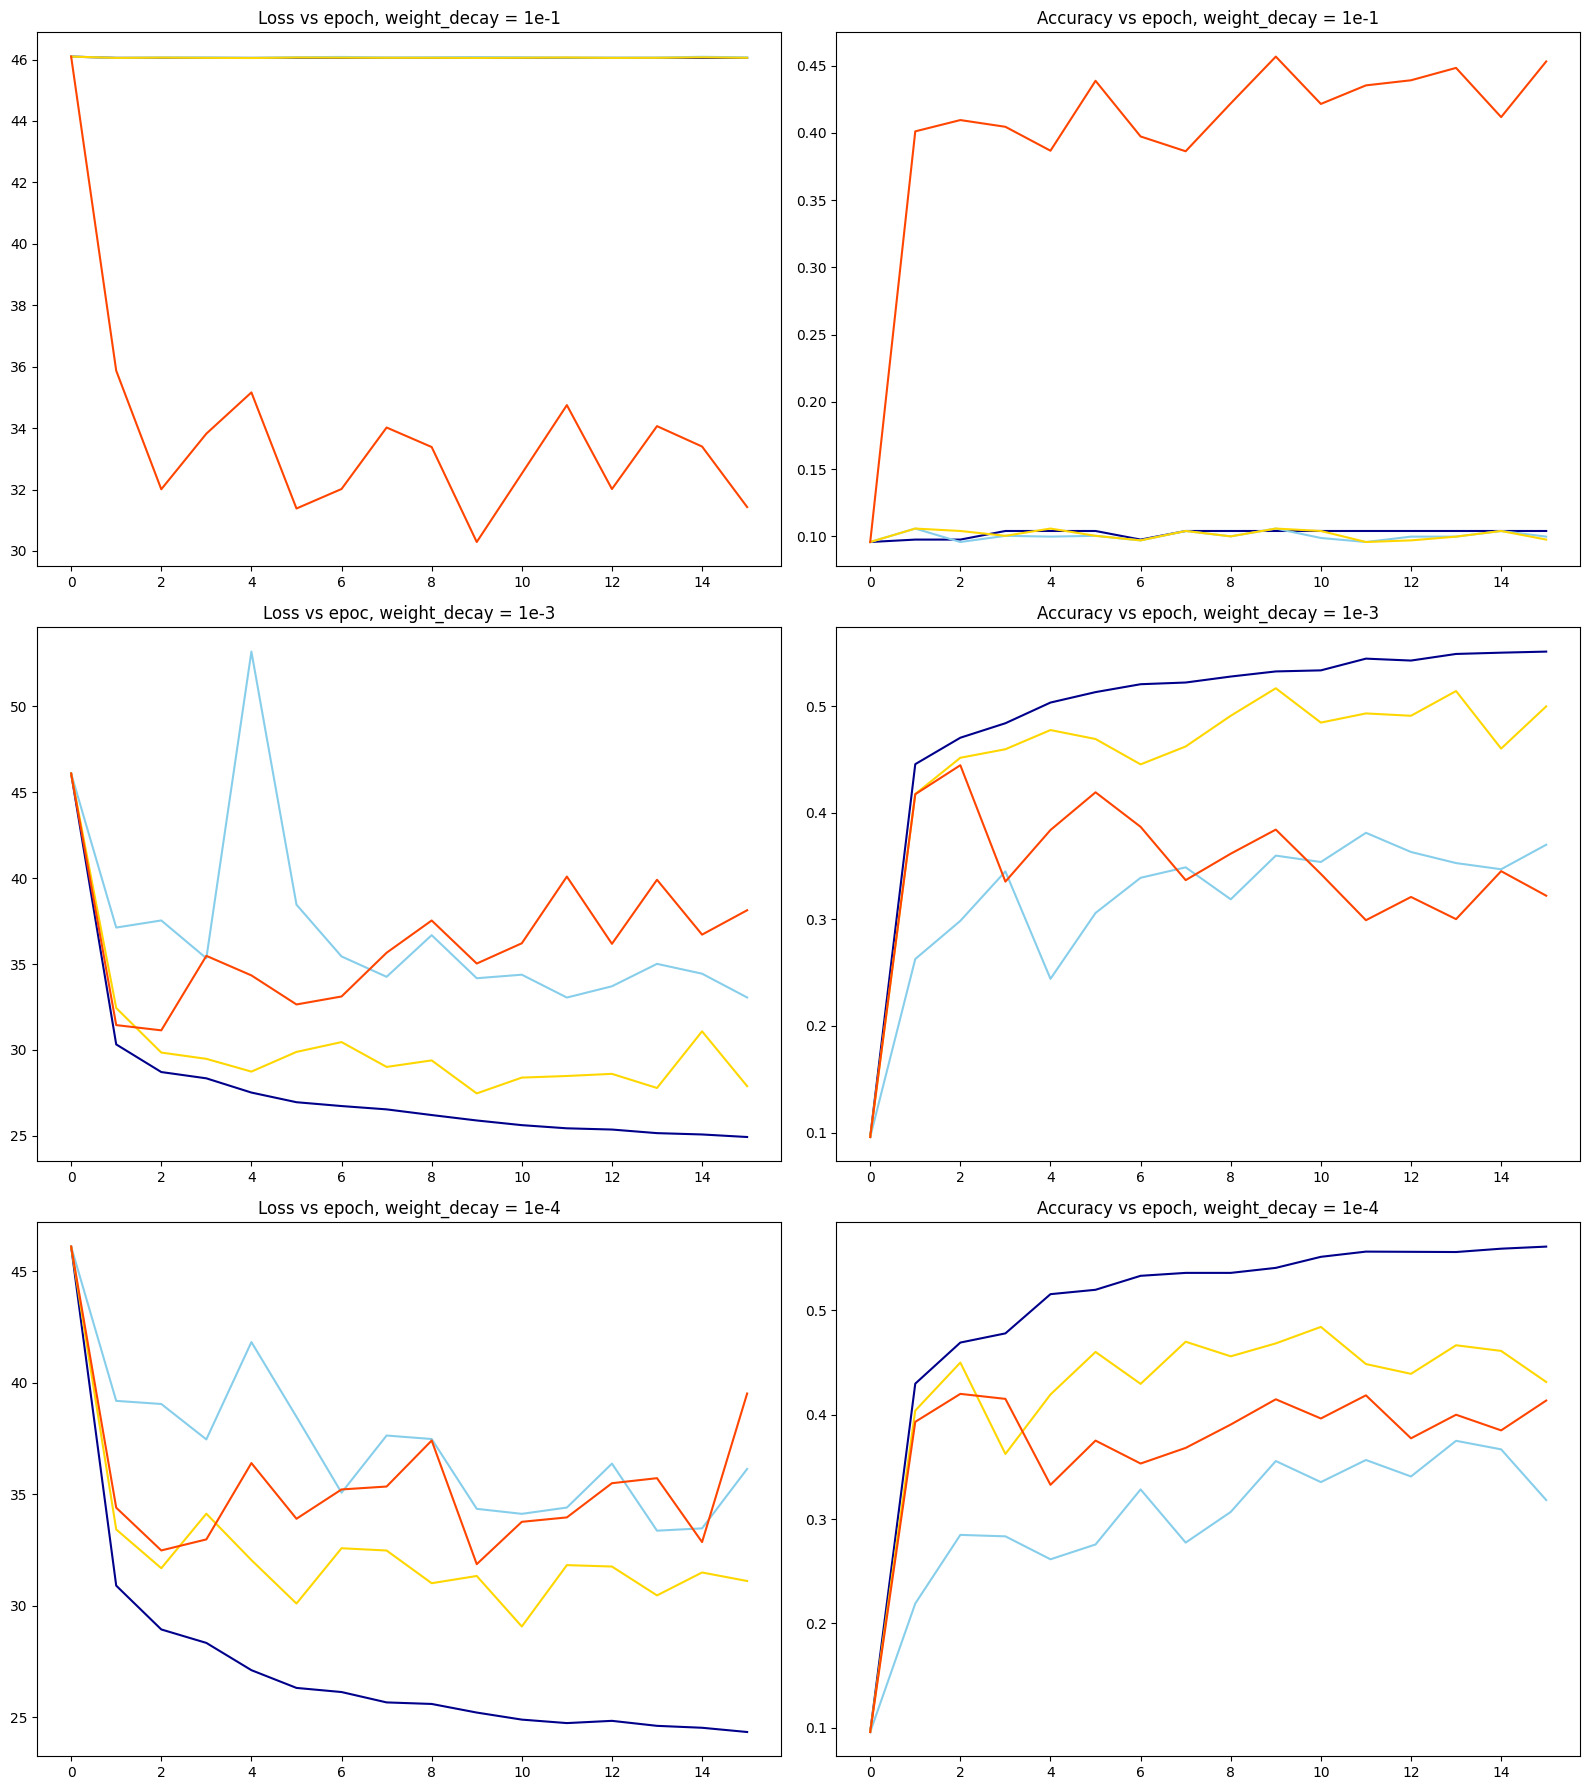

In [68]:
fig, ax = plt.subplots(3, 2, figsize=(16, 18))

ax[0][0].plot(results_1["Adagrad"]["Epoch"], results_1["Adagrad"]["Test Loss"], color="darkblue", label="Adagrad")
ax[0][0].plot(results_1["RMSprop"]["Epoch"], results_1["RMSprop"]["Test Loss"], color="skyblue", label="RMSprop")
ax[0][0].plot(results_1["Adam"]["Epoch"], results_1["Adam"]["Test Loss"], color="gold", label="Adam")
ax[0][0].plot(results_1["AdamW"]["Epoch"], results_1["AdamW"]["Test Loss"], color="orangered", label="AdamW")
ax[0][0].set_title("Loss vs epoch, weight_decay = 1e-1")

ax[0][1].plot(results_1["Adagrad"]["Epoch"], torch.stack(results_1["Adagrad"]["Accuracy"]).cpu(), color="darkblue", label="Adagrad")
ax[0][1].plot(results_1["RMSprop"]["Epoch"], torch.stack(results_1["RMSprop"]["Accuracy"]).cpu(), color="skyblue", label="RMSprop")
ax[0][1].plot(results_1["Adam"]["Epoch"], torch.stack(results_1["Adam"]["Accuracy"]).cpu(), color="gold", label="Adam")
ax[0][1].plot(results_1["AdamW"]["Epoch"], torch.stack(results_1["AdamW"]["Accuracy"]).cpu(), color="orangered", label="AdamW")
ax[0][1].set_title("Accuracy vs epoch, weight_decay = 1e-1")

ax[1][0].plot(results_3["Adagrad"]["Epoch"], results_3["Adagrad"]["Test Loss"], color="darkblue", label="Adagrad")
ax[1][0].plot(results_3["RMSprop"]["Epoch"], results_3["RMSprop"]["Test Loss"], color="skyblue", label="RMSprop")
ax[1][0].plot(results_3["Adam"]["Epoch"], results_3["Adam"]["Test Loss"], color="gold", label="Adam")
ax[1][0].plot(results_3["AdamW"]["Epoch"], results_3["AdamW"]["Test Loss"], color="orangered", label="AdamW")
ax[1][0].set_title("Loss vs epoc, weight_decay = 1e-3")

ax[1][1].plot(results_3["Adagrad"]["Epoch"], torch.stack(results_3["Adagrad"]["Accuracy"]).cpu(), color="darkblue", label="Adagrad")
ax[1][1].plot(results_3["RMSprop"]["Epoch"], torch.stack(results_3["RMSprop"]["Accuracy"]).cpu(), color="skyblue", label="RMSprop")
ax[1][1].plot(results_3["Adam"]["Epoch"], torch.stack(results_3["Adam"]["Accuracy"]).cpu(), color="gold", label="Adam")
ax[1][1].plot(results_3["AdamW"]["Epoch"], torch.stack(results_3["AdamW"]["Accuracy"]).cpu(), color="orangered", label="AdamW")
ax[1][1].set_title("Accuracy vs epoch, weight_decay = 1e-3")

ax[2][0].plot(results_4["Adagrad"]["Epoch"], results_4["Adagrad"]["Test Loss"], color="darkblue", label="Adagrad")
ax[2][0].plot(results_4["RMSprop"]["Epoch"], results_4["RMSprop"]["Test Loss"], color="skyblue", label="RMSprop")
ax[2][0].plot(results_4["Adam"]["Epoch"], results_4["Adam"]["Test Loss"], color="gold", label="Adam")
ax[2][0].plot(results_4["AdamW"]["Epoch"], results_4["AdamW"]["Test Loss"], color="orangered", label="AdamW")
ax[2][0].set_title("Loss vs epoch, weight_decay = 1e-4")

ax[2][1].plot(results_4["Adagrad"]["Epoch"], torch.stack(results_4["Adagrad"]["Accuracy"]).cpu(), color="darkblue", label="Adagrad")
ax[2][1].plot(results_4["RMSprop"]["Epoch"], torch.stack(results_4["RMSprop"]["Accuracy"]).cpu(), color="skyblue", label="RMSprop")
ax[2][1].plot(results_4["Adam"]["Epoch"], torch.stack(results_4["Adam"]["Accuracy"]).cpu(), color="gold", label="Adam")
ax[2][1].plot(results_4["AdamW"]["Epoch"], torch.stack(results_4["AdamW"]["Accuracy"]).cpu(), color="orangered", label="AdamW")
ax[2][1].set_title("Accuracy vs epoch, weight_decay = 1e-4")

plt.tight_layout()
plt.show()

Когда ```weight_decay``` маленький, лучшую сходимость и качество имеет ```Adagrad```. ```AdamW``` не даёт выигрыша по сравнению с ```Adam```, однако это единственный метод, который сходится при большом ```weight_decay```.

### Дополнительная часть

__Задача 1 (5 баллов).__ Сложность достижения быстрой сходимости и качественных решений во многом зависит от выбранной скорости обучения. Приложения с большим количеством агентов, каждый из которых имеет свой оптимизатор, усложняют настройку скорости обучения. Некоторые оптимизаторы, настраиваемые вручную, показывают хорошие результаты, но эти методы обычно требуют квалификации специалистов и трудоемкой работы. Поэтому в последние годы для оптимизации без изменения скорости обучения стали популярны «беспараметрические» методы адаптивной скорости обучения (_parameter-free methods_). В этой задаче мы познакомимся с основными из них.


__а) (1.5 балла)__ Первым рассмотрим метод ```COCOB``` (хыхы) (см. [статью](https://arxiv.org/pdf/1705.07795)). Он основан на схеме ставок на монету, когда на каждой итерации ставится определенная сумма денег на исход подбрасывания монеты таким образом, чтобы максимизировать общее богатство, находящееся в распоряжении. Франческо Орабона применяет ту же идею к оптимизации функции, где ставка соответствует размеру шага, сделанного вдоль оси независимой переменной. Общее богатство и результат броска монеты соответствуют
точке оптимума функции и отрицательному субградиенту функции в точке ставки, соответственно. В каждом раунде ставится часть текущего общего богатства (точка оптимума). Стратегия ставок разработана таким образом, что общее богатство не становится отрицательным ни в одной точке, а доля поставленных денег в каждом раунде увеличивается до тех пор, пока исход броска монеты не станет постоянным.


In [ ]:
class COCOB(Optimizer):
    """
    Implements the COCOB algorithm, which has been proposed in 
    `Training Deep Networks without Learning Rates Through Coin Betting`
    https://arxiv.org/abs/1705.07795 .
    
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        alpha (float, optional): It was proposed to increase the stability in the first iterations,
            similarly and independently to the learning rate warm-up. The number roughly denotes the
            number of rounds of warm-up (default 100)
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
    """
    def __init__(self, params, alpha: float = 100, eps: float = 1e-8, weight_decay: float = 0):
        defaults = dict(weight_decay=weight_decay, lr=1.0)
        self._alpha = alpha
        self._eps = eps
        super(COCOB, self).__init__(params, defaults)
    @torch.no_grad()
    def step(self, closure = None):
        """
        Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
        
        for group in self.param_groups:
            
            for p in group['params']:
                
                # Ваше решение
                ...
                                
        return loss

In [ ]:
# Ваше решение

__б) (1.5 балла)__ Вторым же _paramter-free_ методом будет ```Prodigy```, недавно представленный в работе [Prodigy: An Expeditiously Adaptive Parameter-Free Learner](https://arxiv.org/pdf/2306.06101). В нем используется чуть более продвинутое решение, а именно использование адаптивного шага, как в ```AdaGrad```. Обновление также использует скользящее среднее, хотя оно более консервативно, поскольку использует $\sqrt{\beta_2}$ вместо $\beta_2$. Обратите внимание, что в обновлении для $v_k$ присутствует дополнительное значение $(1 - \beta_2)$, которое может быть опционально компенсировать с помощью поправки на смещение.

In [ ]:
import torch.distributed as dist
import math
class Prodigy(torch.optim.Optimizer):
    """
    Implements Adam with Prodigy step-sizes.
    Leave LR set to 1e-1 unless you encounter instability.
   
    Arguments:
        params (iterable):
            Iterable of parameters to optimize or dicts defining parameter groups.
        lr (float):
            Learning rate adjustment parameter. Increases or decreases the Prodigy learning rate.
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        beta3 (float):
            coefficients for computing the Prodidy stepsize using running averages.
            If set to None, uses the value of square root of beta2 (default: None).
        eps (float):
            Term added to the denominator outside of the root operation to improve numerical stability. (default: 1e-8).
        weight_decay (float):
            Weight decay, i.e. a L2 penalty (default: 0).
        decouple (boolean):
            Use AdamW style decoupled weight decay
        use_bias_correction (boolean):
            Turn on Adam's bias correction. Off by default.
        safeguard_warmup (boolean):
            Remove lr from the denominator of D estimate to avoid issues during warm-up stage. Off by default.
        d0 (float):
            Initial D estimate for D-adaptation (default 1e-6). Rarely needs changing.
        d_coef (float):
            Coefficient in the expression for the estimate of d (default 1.0).
            Values such as 0.5 and 2.0 typically work as well. 
            Changing this parameter is the preferred way to tune the method.
            
        growth_rate (float):
            prevent the D estimate from growing faster than this multiplicative rate.
            Default is inf, for unrestricted. Values like 1.02 give a kind of learning
            rate warmup effect.
        fsdp_in_use (bool):
            If you're using sharded parameters, this should be set to True. The optimizer
            will attempt to auto-detect this, but if you're using an implementation other
            than PyTorch's builtin version, the auto-detection won't work.
    """
    def __init__(self, params, lr=1.0,
                 betas=(0.9, 0.999), beta3=None,
                 eps=1e-8, weight_decay=0, decouple=True, 
                 use_bias_correction=False, safeguard_warmup=False,
                 d0=1e-6, d_coef=1.0, growth_rate=float('inf'),
                 fsdp_in_use=False):
        if decouple and weight_decay > 0:
            print(f"Using decoupled weight decay")
       
        defaults = dict(lr=lr, betas=betas, beta3=beta3,
                        eps=eps, weight_decay=weight_decay,
                        d=d0, d0=d0, d_max=d0,
                        d_numerator=0.0, d_coef=d_coef,
                        k=0, growth_rate=growth_rate,
                        use_bias_correction=use_bias_correction,
                        decouple=decouple, safeguard_warmup=safeguard_warmup,
                        fsdp_in_use=fsdp_in_use)
        self.d0 = d0
        super().__init__(params, defaults)
    def step(self, closure=None):
        """
        Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            
            loss = closure()

        # Ваше решение
        ...
        for group in self.param_groups:
            
            # Ваше решение
            ...
        return loss

In [ ]:
# Ваше решение

__в) (2 балла)__ Немного отклонимся от темы безпараметрических методов, и вернемся к проксимальному оператору, который возникает при использовании композита (регуляризационного члена). При этом, единственное предположение, которое делается о функции композита -- что он выпуклый. То есть в общем случае предполагать его дифференцируемость нельзя. Рассмотрим пример такого композита -- регуляризацию Tikhanov + Lasso (также известную как $L_1 + L_2$/$L_{12}$/ElasticNet). То есть задача оптимизации превращается в следующую:
$$
\min F(x) \coloneqq \frac{1}{n}\sum \limits_{i = 1}^n f_i(x) + \alpha \| x \|_1 + (1 - \alpha) \| x \|_2^2
$$
Вычислите проксимальный оператор для такой функции и реализуйте метод ProxSGD (можно с моментом, можно без), проведите эксперименты для разных значений параметра $\alpha$ (который также называют $L_1$-ratio). Например, для: 0, 0.1, 0.3, 0.6, 0.9, 1.

In [ ]:
from torch.optim.optimizer import required
from copy import deepcopy
class ProxSGD(Optimizer):
    """
    Adaptation of  torch.optim.SGD to proximal stochastic gradient descent (optionally with momentum).
    Nesterov momentum is based on the formula from
    
    `On the importance of initialization and momentum in deep learning`__.
    Arguments:
     params (iterable):
            Iterable of parameters to optimize or dicts defining parameter groups.
        lr (float):
            Learning rate adjustment parameter. Increases or decreases the Prodigy learning rate.
        alpha (float, optional): 
            
            l1-ratio used in the regularizer.
        momentum (float, optional): 
            
            momentum factor (default: 0)
    """
    def __init__(self, params, lr=required, alpha=0.5, momentum=0.,):
        self.alpha = alpha
        defaults = dict(lr=lr, momentum=momentum)
        super().__init__(params, defaults)
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                
                loss = closure()
        for group in self.param_groups:
            for p in group['params']:
                
                # Ваше решение
                ...
        return loss

In [ ]:
# Ваше решение